# Conference Session Scheduling using Graphs

The basic problem: given a large conference with several parallel sessions, how can we schedule sessions in such a way that those of the same topic do not occur in the same time slot? 

Terminology:
* **session $s$**: a single conference session of a given topic
* **time slot $t$**: the date/time at which a session could occur
* **rooms $r$**: the number of available slots for sessions in each time slot

There will be $T$ time slots in the conference and $R$ rooms per time slot, allowing for a total of $S = RT$ sessions to be scheduled. 

The simplest version of the problem is the following: each session has a topic $c$ associated with it. No two sessions with the same topic may be scheduled at the same time. In a less constrained version of the problem, each session may have $n$ different topics $c$ associated with it, in decreasing order of importance. We wish to solve such that sessions who have the same topic at the first position are unlikely to be scheduled at the same time, but that for each topic down the ranked list, the constraint of co-scheduling two sessions with the same two topics at that position becomes increasingly less important.

Either way, we are going to build a graph to solve this problem. For this graph, we take all sessions in $S$ as nodes and draw edges $e$ between all sessions that may co-exist in the same time slot. For the simple version of the problem, the edges will have weight $1$ if the topics are different (i.e. both sessions may coexist in the same time slot) and $0$ otherwise. The problem then reduces to finding closed loops in this graph. 
For a conference with three parallel sessions, we would like to find triangles in this graph (corresponding to three nodes (i.e. sessions) that may all coexist with each other in the same time slot). For conferences with more parallel session, one must choose correspondingly longer paths. 

We can choose an iterative approach to brute-force the selection: 
* find all available triangles and order them in some way
* pick the first triangle, remove from the graph, do the same thing again
* recurse
* if we end up with a solution that leaves no sessions unscheduled, we're done
* if not, back up a step, recurse again, or back up one step further, recurse again

Note: in the strict problem with only one topic, there may be no complete solutions. We probably need to account for that somehow.
In the problem with various topics of different and decreasing importance, we will have multiple edges between nodes, each of which will be one if the edge exists, and different (small) fractions if the edge doesn't exist. Maybe, for the most important topic, it will be zero. For the second, slightly less important topic, it might be 0.1, and so forth. We will multiply all weights together to get a total weight that depends on all topics.
Then, we find all triangles and add up the weights, and order them by weight from largest to smallest. The rest of the procedure follows as before.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import networkx as nx


Let's make a graph:

In [2]:
G=nx.Graph()

Okay, let's start with an example. We are going to have five time slots and three rooms, that gives us a total of fifteen session. We will also have six different session types, and we're going to pick them randomly.

In [3]:
## set the random seed
np.random.seed(20160110)

In [4]:
## make a list of indices
sessions = np.arange(15)

## session topics:
topics = ["exoplanets", "galaxies", "cosmology", "compact_objects", "agn", "stars"]

## randomly select the session labels:
session_labels = np.random.choice(topics, size=sessions.shape[0])

print("all the session labels:" + str(session_labels))

all the session labels:['compact_objects' 'compact_objects' 'agn' 'agn' 'stars' 'cosmology'
 'exoplanets' 'cosmology' 'cosmology' 'compact_objects' 'agn' 'cosmology'
 'cosmology' 'galaxies' 'exoplanets']


Now we can set the nodes of the graph:

In [5]:
for s,l in zip(sessions, session_labels):
    G.add_node(s, topic=l)

In [6]:
G.nodes[1]["topic"]

'compact_objects'

Now we can also add weights to the edges. We'll add an edge with weight $1$ if the topics are not the same and no weight if the topics are the same:

In [7]:
for i in sessions:
    for j in sessions:
        if session_labels[i] == session_labels[j]:
            continue
        else:
            G.add_edge(i,j,weight=1.0)

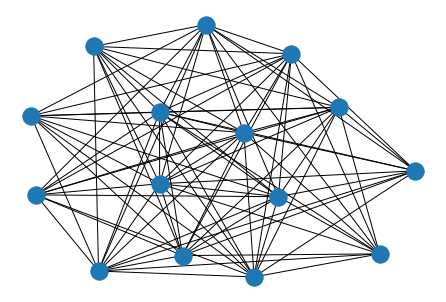

In [8]:
nx.draw(G)

So now that we have the graph, let's solve our first problem: find all triangles:

In [9]:
cliques = list(nx.enumerate_all_cliques(G))

In [10]:
cliques = [c for c in cliques if len(c)==5]
print(cliques[:10])

[[0, 2, 4, 5, 6], [0, 2, 4, 5, 13], [0, 2, 4, 5, 14], [0, 2, 4, 6, 7], [0, 2, 4, 6, 8], [0, 2, 4, 6, 11], [0, 2, 4, 6, 12], [0, 2, 4, 6, 13], [0, 2, 4, 7, 13], [0, 2, 4, 7, 14]]


Awesome, now we can do this recursively:

In [11]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14))

In [12]:
import copy

def add_edges(G):
    sessions = G.nodes()
    nsessions = len(sessions)
    for si in sessions:
        for sj in sessions:
            if G.nodes()[si]["topic"] == G.nodes()[sj]["topic"]:
                continue
            else:
                G.add_edge(si, sj, weight=1.0)
    return G

triangles = []
n_unused = len(sessions)

def recursively_select_triangles(triangles, G, n_unused):

    cliques = list(nx.enumerate_all_cliques(G))
    cliques = [c for c in cliques if len(c)==3]
    ncliques = len(cliques)
    
    #print("ncliques: " + str(ncliques))
    
    if ncliques == 0:
        tnew = list(triangles.pop(np.random.choice(np.arange(len(triangles)))))
        #print("tnew : " + str(list(tnew)))
        G_new = copy.deepcopy(G)
        for t in tnew:
            #print("t: " + str(t[0]))
            G_new.add_node(t[0], topic=t[1])

        #print(G_new.nodes())
        G_new = add_edges(G_new)
        n_unused = G_new.number_of_nodes()
        #print("n_unused: " + str(n_unused))
        return recursively_select_triangles(triangles, G_new, n_unused)
    
    index = np.random.choice(np.arange(len(cliques)))
    tnew = cliques[index]
    tnew_topics = [G.nodes[c]["topic"] for c in tnew]
    triangles.append(zip(tnew, tnew_topics))
    G_new = copy.deepcopy(G)
    for n in cliques[index]:
        G_new.remove_node(n)
    
    n_unused = G_new.number_of_nodes()
    
    if n_unused == 0:
        return triangles
    else:
        return recursively_select_triangles(triangles, G_new, n_unused)
        


ncliques: 258
ncliques: 120
ncliques: 51
ncliques: 6
ncliques: 0

In [13]:
triangles = []
triangles = recursively_select_triangles(triangles, G, n_unused)

In [14]:
for t in triangles:
    print(list(t))

[(3, 'agn'), (6, 'exoplanets'), (11, 'cosmology')]
[(0, 'compact_objects'), (2, 'agn'), (5, 'cosmology')]
[(7, 'cosmology'), (13, 'galaxies'), (14, 'exoplanets')]
[(12, 'cosmology'), (4, 'stars'), (9, 'compact_objects')]
[(1, 'compact_objects'), (8, 'cosmology'), (10, 'agn')]


Okay, cool! That seems to work in principle. I think I'll probably need some checks and balances in the future, but the basic framework is there. 

Let's clean that up a little:

In [15]:
def add_edges(G, label="topic", weight=1.0):
    
    sessions = G.nodes()
    nsessions = len(sessions)
    for si in sessions:
        for sj in sessions:
            if G.nodes()[si][label] == G.nodes()[sj][label]:
                continue
            else:
                G.add_edge(si, sj, weight=weight)
    return G



In [16]:
groups = []
n_unused = len(sessions)
n_counter = 0

def recursively_select_groups(G, groups, n_unused, n_elements, n_counter=0, label="topic"):
    """
    This function recursively splits up the available graph G into 
    cliques of n_elements members. Note: this will probably break if 
    there is no solution, so I should add a check for that!
    
    Parameters
    ----------
    G : networkx.Graph instance
        The graph containing the data (session number, topic)
    
    groups : list of lists
        The list containing all final cliques of the solution
    
    n_unused : int
        A variable counting the number of unused nodes in the graph
        
    n_elements : int
        The number of elements in each clique
    
    label : string, default "topic"
        The label describing each node in the graph
        
    Returns
    -------
    groups: The list containing all final cliques of the solution
    
    """
    n_counter += 1
    
    if n_counter > 200:
        print("No full solution found!")
        remainder = G.nodes()
        if len(remainder) == n_elements:
                tnew_topics = [G.nodes[c]["topic"] for c in remainder]
                ## add the new clique to the list of output groups
                groups.append(list(zip(remainder, tnew_topics)))
        return groups, remainder
    #print("number of nodes: " + str(G.number_of_nodes()))
    #print("n_elements: " + str(n_elements))
    #print("remainder: " + str(G.number_of_nodes() % np.float(n_elements)))
    
    ## TODO: add assertion that X*n_elements == G.number_of_nodes()
    assert G.number_of_nodes() % np.float(n_elements) == 0, "Number of sessions must be " + \
                                "an integer multiple of n_elements"
    
    #print("length of G: " + str(len(G.nodes())))
    ## find all cliques in the graph G
    cliques = list(nx.enumerate_all_cliques(G))
    
    #print("cliques: " + str(cliques))
    len_cliques = [len(c) for c in cliques]
    ## find all cliques that have the required number of elements
    cliques = [c for c in cliques if len(c)==n_elements]
    
    #print("cliques after search: " + str(cliques))
    
    ## find the total number of cliques with n_elements members
    ncliques = len(cliques)
    #print("ncliques: " + str(ncliques))
    ## if there are no cliques, back up a step:
    if ncliques == 0:
        ## pick an already selected clique at random:
        index = np.random.choice(np.arange(len(groups)))
        ## take out the selected group
        tnew = groups.pop(index)
        ## add it back to the graph
        G_new = copy.deepcopy(G)
        for t in tnew:
            G_new.add_node(t[0], topic=t[1])
            
        ## add the edges back to the graph
        G_new = add_edges(G_new)
        
        ## new unused number of nodes
        n_unused = G_new.number_of_nodes()
        ## recurse
        return recursively_select_groups(G_new, groups, n_unused, n_elements, n_counter, label=label)
    
    ## pick a new clique at random:
    index = np.random.choice(np.arange(len(cliques)))
    ## extract the clique number and label
    tnew = cliques[index]
    tnew_topics = [G.nodes[c]["topic"] for c in tnew]
    
    ## add the new clique to the list of output groups
    groups.append(list(zip(tnew, tnew_topics)))
    G_new = copy.deepcopy(G)
    
    ## remove clique from graph
    for n in cliques[index]:
        G_new.remove_node(n)
    
    ## compute new unused number of nodes
    n_unused = G_new.number_of_nodes()
    
    #print("n_unused: " + str(n_unused))
    #print("\n")
    ## if no unused nodes are left, return the selected groups,
    ## otherwise recurse
    if n_unused == 0:
        remainder = []
        return groups, remainder
    else:
        return recursively_select_groups(G_new, groups, n_unused, n_elements, n_counter, label=label)
        


In [17]:
groups = []
groups, remainder = recursively_select_groups(G, groups, n_unused, n_elements=5, label="topic")

No full solution found!


In [18]:
groups

[[(12, 'cosmology'),
  (0, 'compact_objects'),
  (2, 'agn'),
  (13, 'galaxies'),
  (14, 'exoplanets')],
 [(11, 'cosmology'),
  (10, 'agn'),
  (1, 'compact_objects'),
  (4, 'stars'),
  (6, 'exoplanets')],
 [(7, 'cosmology'),
  (9, 'compact_objects'),
  (5, 'cosmology'),
  (8, 'cosmology'),
  (3, 'agn')]]

## Including multiple topics and weights

Let's try a more complex problem: each session now has two attributes. The first attribute must not clash, but the second might with some probability. 

First, we'll need another set of labels for our sessions:

In [19]:
session_labels2 = np.random.choice(topics, size=sessions.shape[0])

In [20]:
for i in range(len(session_labels2)):
    G.nodes[i]["topic2"] = session_labels2[i]

In [21]:
G.nodes(data=True)

NodeDataView({0: {'topic': 'compact_objects', 'topic2': 'agn'}, 1: {'topic': 'compact_objects', 'topic2': 'agn'}, 2: {'topic': 'agn', 'topic2': 'agn'}, 3: {'topic': 'agn', 'topic2': 'exoplanets'}, 4: {'topic': 'stars', 'topic2': 'stars'}, 5: {'topic': 'cosmology', 'topic2': 'stars'}, 6: {'topic': 'exoplanets', 'topic2': 'agn'}, 7: {'topic': 'cosmology', 'topic2': 'cosmology'}, 8: {'topic': 'cosmology', 'topic2': 'cosmology'}, 9: {'topic': 'compact_objects', 'topic2': 'compact_objects'}, 10: {'topic': 'agn', 'topic2': 'stars'}, 11: {'topic': 'cosmology', 'topic2': 'exoplanets'}, 12: {'topic': 'cosmology', 'topic2': 'cosmology'}, 13: {'topic': 'galaxies', 'topic2': 'cosmology'}, 14: {'topic': 'exoplanets', 'topic2': 'compact_objects'}})

Now we can actually modify our `add_edges` function such that it does the right thing:

In [22]:
G.edges()

EdgeView([(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 11), (2, 12), (2, 13), (2, 14), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 11), (3, 12), (3, 13), (3, 14), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (5, 6), (5, 9), (5, 10), (5, 13), (5, 14), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (7, 9), (7, 10), (7, 13), (7, 14), (8, 9), (8, 10), (8, 13), (8, 14), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (10, 11), (10, 12), (10, 13), (10, 14), (11, 13), (11, 14), (12, 13), (12, 14), (13, 14)])

In [23]:
G.edges()[0,2]

{'weight': 1.0}

In [24]:
def add_edges(G, labels=None, hard_constraint=True, weights=None):
    """
    Add edges to the graph, with weights.
    Weights are determined by by the importance weights on
    each label.

    If no order of labels is
    specified, then the order of keys in the dictionary
    for each node will be used.

    TODO: Make hard_constraint an *index* rather than a bool

    Parameters
    ----------
    G : networkx.Graph() instance
        The graph without edges

    labels : list of strings
        A list of labels specifying the order of attributes on each
        node to use when calculating the weights.
        This list should be in descending order (with the most important
        label *first*).
        If none are specified, then the order of keywords in the
        dictionary of attributes for each node will be used.

    hard_constraint : bool
        Boolean flag determining whether hard constraints should be used.
        In this case, this means that for the first label specified in
        `labels`, no edges will be drawn when this label is the same
        for two nodes.

    weights : iterable of float (0, 1]
        The relative weights of each category. By default, the weight of an
        edge will be `weight=1`, adjusted by `weight[i]` for each pair of nodes
        where the labels in category `i` are the same. If `hard_constraints==True`,
        then edges between nodes for which labels in the first category are
        the same do not exist, and `weights` should have length `len(labels)-1`.
        If `hard_constraints == False`, then `len(weights)` should be `len(labels)`,
        where the first entry is used to set the weight of an edge between two
        nodes where `label[0]` has the same value.


    Returns
    -------
    G : networkx.Graph() instance
        The same input graph, but with edges.
    """

    # find the total number of labels
    nlabels = len(labels)

    if weights is not None:
        if hard_constraint:
            assert nlabels-1 == len(weights), "Number of weights must correspond" \
                                              "to the number of topics"
        else:
            assert nlabels == len(weights), "Number of weights must correspond" \
                                        "to the number of topics"

    else:
        weights = np.ones(nlabels)

    # the total number of nodes
    n_nodes = G.number_of_nodes()

    # list of nodes
    nodes = G.nodes()

    # get a list of lists of all node labels
    node_labels = []
    for l in labels:
        node_labels.append([G.nodes()[i][l] for i in G.nodes()])

    # TODO: Currently only works with two labels!
    # iterate over all the different possible labels
    for i, sl in enumerate(node_labels):
        # iterate over all nodes
        for k, n1 in enumerate(G.nodes()):
            for l, n2 in enumerate(G.nodes()):
                #print("n1: " + str(n1))
                #print("n2: " + str(n2))
                # if sessions have the same label,
                # either make no node (for first label),
                # or weaken a node that's already there
                if k == l:
                    #print("k == l, continuing")
                    continue
                if k > l:
                    #print("k > l, continuing")
                    continue

                if hard_constraint:
                    #print("using hard constraints")
                    if i == 0:
                        #print("First label")
                        if G.nodes()[n1][labels[i]] == G.nodes()[n2][labels[i]]:
                            #print("Labels are the same, continuing")
                            continue
                        else:
                            #print("Making edge between %i and %i of weight %.2f"%(n1, n2, weights[i]))
                            G.add_edge(n1, n2, weight=1.0)
                    else:
                        #print("Second pass")
                        if G.nodes()[n1][labels[i]] == G.nodes()[n2][labels[i]]:
                            if (n1, n2) not in G.edges():
                                continue
                            else:
                                G[n1][n2]["weight"] *= weights[i-1]
                        else:
                            #print("labels are not the same. Not doing anything.")
                            continue
                else:
                    if i == 0:
                        if G.nodes()[n1][labels[i]] == G.nodes()[n2][labels[i]]:
                            G.add_edge(n1, n2, weight=weights[i])
                        else:
                            G.add_edge(n1, n2, weight=1.0)
                    else:
                        if G.nodes()[n1][labels[i]] == G.nodes()[n2][labels[i]]:
                            G[n1][n2]["weight"] *= weights[i]
                        else:
                            continue

    return G



In [25]:
G.remove_edges_from(G.edges())

In [26]:
G.edges()

EdgeView([])

In [27]:
G = add_edges(G, labels=["topic", "topic2"])

In [28]:
G.nodes(data=True)

NodeDataView({0: {'topic': 'compact_objects', 'topic2': 'agn'}, 1: {'topic': 'compact_objects', 'topic2': 'agn'}, 2: {'topic': 'agn', 'topic2': 'agn'}, 3: {'topic': 'agn', 'topic2': 'exoplanets'}, 4: {'topic': 'stars', 'topic2': 'stars'}, 5: {'topic': 'cosmology', 'topic2': 'stars'}, 6: {'topic': 'exoplanets', 'topic2': 'agn'}, 7: {'topic': 'cosmology', 'topic2': 'cosmology'}, 8: {'topic': 'cosmology', 'topic2': 'cosmology'}, 9: {'topic': 'compact_objects', 'topic2': 'compact_objects'}, 10: {'topic': 'agn', 'topic2': 'stars'}, 11: {'topic': 'cosmology', 'topic2': 'exoplanets'}, 12: {'topic': 'cosmology', 'topic2': 'cosmology'}, 13: {'topic': 'galaxies', 'topic2': 'cosmology'}, 14: {'topic': 'exoplanets', 'topic2': 'compact_objects'}})

### Searching for groups with proper back-tracking

In order to find the solution, I should probably do the backtracking properly.


In [29]:
def find_groups_with_backtracking(G, groups, n_elements, n_unused, n_counter=0):

    n_counter += 1
    
    if n_counter > 200:
        print("No full solution found!")
        remainder = G.nodes()
        if len(remainder) == n_elements:
            cl_topics = [G.nodes()[c] for c in cl]
            groups.append(list(zip(cl, cl_topics)))

            return False

    
    assert G.number_of_nodes() % np.float(n_elements) == 0, "Number of sessions must be " + \
                                "an integer multiple of n_elements"

    label = "topic" ## quick hack for testing, will take care of labels later!
    
    ## base case
    if n_unused == 0:
        return True
    
    else:
        ## find all cliques in the graph G
        cliques = list(nx.enumerate_all_cliques(G))
    
        ## find all cliques that have the required number of elements
        cliques = [c for c in cliques if len(c)==n_elements]

        ## find the total number of cliques with n_elements members
        ncliques = len(cliques)

        for cl in cliques:
            cl_topics = [G.nodes()[c] for c in cl]
            
            ## add the new clique to the list of output groups
            groups.append(list(zip(cl, cl_topics)))
            G_new = copy.deepcopy(G)
    
            ## remove clique from graph
            for n in cl:
                G_new.remove_node(n)
    
            ## compute new unused number of nodes
            n_unused = G_new.number_of_nodes()
    
            ## if no unused nodes are left, return the selected groups,
            ## otherwise recurse
            if find_groups_with_backtracking(G_new, groups, n_elements, n_unused, n_counter):
                return True
            
            else:
                groups.pop(-1)
                


In [30]:
groups = []
n_elements = 3
n_unused = G.number_of_nodes()
test_groups = find_groups_with_backtracking(G, groups, n_elements, n_unused)

We've already changed `add_edges` so it can deal with multiple labels. Now we need to add the weights to the recursion. The weights essentially modify the edges in such a way that cliques with a smaller weight will have less of a chance to be picked:

In [31]:
G[0][2]

{'weight': 1.0}

In [32]:
def _sort_cliques_by_weights(G, cliques, n_elements):
    """
    Sort cliques by their weights.
    
    Parameters
    ----------
    G : networkx.Graph instance
        Undirected graph with nodes and edges.
        Edges must have attribute 'weight'
        
    cliques : iterable
        A list of lists; inner lists must have n_elements members
    
    n_elements : integer
        The number of elements in each clique
        
    Returns
    -------
    cliques : iterable
        All cliques sorted by weights in descending order
        
    summed_weights : iterable
        The list of summed weights, sorted in the 
        same descending order as cliques
    
    """
    ## compute summed weights for all cliques:
    summed_weights = []
    for cl in cliques:
        ww = 0
        for i in range(n_elements):
            for j in range(n_elements):
                if i >= j:
                    continue
                else:
                    ww += G[cl[i]][cl[j]]["weight"]

        summed_weights.append(ww)

    ## sort cliques from highest weight to smallest
    sorted_cliques = cliques[np.argsort(summed_weights)[::-1]]
    ## sort weights in the same way
    summed_weights = np.sort(summed_weights)[::-1]

    return sorted_cliques, summed_weights



def find_groups_with_weights(G, groups, n_elements, n_unused=None, weights_total_sum=None):
    """
    Sort nodes in G into groups of n_elements members such that 
    the total sum of weights is maximized. 
    If the graph includes hard constraints on the relationship between 
    nodes (i.e. missing edges), it is possible that no solution is found.
    
    In the case of a fully connected graph, the solution will be that 
    which maximizes the weights. The weights are inherent attributes of 
    the Graph and must be calculated beforehand (see `add_edges` for details).
    
    Parameters
    ----------
    G : networkx.Graph() instance
        Undirected graph with nodes and edges. The edges must have weights 
        between 0 and 1, but edges can be missing if no relationship exists 
        between nodes.
        
    groups : iterable
        A list of lists containing all groups of n_elements members fulfilling 
        the connectivity constraints that maximize the sum of weights of all 
        groups being used.
        Should be initialized with an empty list, will be modified during the 
        recursion to be filled with the groups.
        
    n_elements : integer
        The number of elements per group. Must be an integer divisor of the 
        total number of nodes in the graph.
        
    n_unused : integer
        The number of unused nodes in the graph at every recursion step. 
        If None, then it will be initialized as the total number of nodes
        in the graph.
    
    weights_total_sum : list
        The total sum of weights of elements in `groups`. 
        If None, then it will be initialized as an empty list to count 
        the sum of weights for each individual group. Will be summed at 
        the end before output into a float value.
        Note: DO NOT SET THIS AT THE BEGINNING OF THE RUN!
        
    Returns
    -------
    success : bool
        Flag indicating success or failure of the algorithm
        
    groups: iterable
        A list of lists containing all groups of n_elements members fulfilling 
        the connectivity constraints that maximize the sum of weights of all 
        groups being used.        
        
    weights_total_sum : float
        The total sum of all weights of the output groups
    
    """
    assert G.number_of_nodes() % np.float(n_elements) == 0, "Number of sessions must be " + \
                                "an integer multiple of n_elements"

    ## if weights_total_sum isn't set, initialize empty list
    if weights_total_sum is None:
        weights_total_sum = []
        
    if n_unused is None:
        n_unused = G.number_of_nodes()

    ## base case
    if n_unused == 0:
        return True, groups, np.sum(weights_total_sum)

    ## recursion
    else:
        ## find all cliques in the graph G
        cliques = list(nx.enumerate_all_cliques(G))
    
        ## find all cliques that have the required number of elements
        cliques = np.array([c for c in cliques if len(c)==n_elements])

        ## sort cliques by weights
        cliques, summed_weights = _sort_cliques_by_weights(G, cliques, n_elements)

        ## find the total number of cliques with n_elements members
        ncliques = len(cliques)

        ## loop over all cliques:
        for cl,ww in zip(cliques, summed_weights):

            cl_topics = [G.nodes()[c] for c in cl]
            
            ## add the new clique to the list of output groups
            groups.append(list(zip(cl, cl_topics)))
            
            ## add total weight of the clique:
            weights_total_sum.append(ww)
            
            ## make a new deep copy for the next recursion step
            G_new = copy.deepcopy(G)
    
            ## remove clique from graph
            for n in cl:
                G_new.remove_node(n)
    
            ## compute new unused number of nodes
            n_unused = G_new.number_of_nodes()
    
            ## if no unused nodes are left, return the selected groups,
            ## otherwise recurse
            if find_groups_with_weights(G_new, groups, n_elements, n_unused, weights_total_sum):
                return True, groups, np.sum(weights_total_sum)
            
            ## backtrack
            else:
                groups.pop(-1)
                weights_total_sum.pop(-1)
    #return False, groups, weights_total_sum


In [33]:
groups = []
n_elements = 3
success, groups, weights_total_sum= find_groups_with_weights(G, groups, n_elements)

In [34]:
success

True

In [35]:
groups

[[(12, {'topic': 'cosmology', 'topic2': 'cosmology'}),
  (13, {'topic': 'galaxies', 'topic2': 'cosmology'}),
  (14, {'topic': 'exoplanets', 'topic2': 'compact_objects'})],
 [(9, {'topic': 'compact_objects', 'topic2': 'compact_objects'}),
  (10, {'topic': 'agn', 'topic2': 'stars'}),
  (11, {'topic': 'cosmology', 'topic2': 'exoplanets'})],
 [(4, {'topic': 'stars', 'topic2': 'stars'}),
  (6, {'topic': 'exoplanets', 'topic2': 'agn'}),
  (8, {'topic': 'cosmology', 'topic2': 'cosmology'})],
 [(1, {'topic': 'compact_objects', 'topic2': 'agn'}),
  (3, {'topic': 'agn', 'topic2': 'exoplanets'}),
  (7, {'topic': 'cosmology', 'topic2': 'cosmology'})],
 [(0, {'topic': 'compact_objects', 'topic2': 'agn'}),
  (2, {'topic': 'agn', 'topic2': 'agn'}),
  (5, {'topic': 'cosmology', 'topic2': 'stars'})]]

In [36]:
weights_total_sum

15.0

Seems to work fine! Let's try a different set of elements:

In [37]:
groups = []
n_elements = 5
success = find_groups_with_weights(G, groups, n_elements, n_unused=G.number_of_nodes())

In [38]:
success

For 5 elements, there is no solution. 
The code doesn't really make that explicit, so let's change it so it does.
For that purpose, we'll introduce a small container class that will contain 
attributes of the results: whether the search was a success, what the output 
cliques are and what the sum of all weights is.


In [39]:
class Results(object):
    
    def __init__(self, n_elements):
        self.n_elements = n_elements
        self.groups = []
        self.all_weights = []
        self.success = True
        
    def update_groups(self, groups):
        self.groups.append(groups)
        
    def update_weights(self, weights_sum_total):
        self.all_weights.append(weights_sum_total)
        self.weights_sum_total = np.sum(self.all_weights)

def find_groups_with_weights(G, n_elements, n_unused=None, results=None):
    """
    Sort nodes in G into groups of n_elements members such that 
    the total sum of weights is maximized. 
    If the graph includes hard constraints on the relationship between 
    nodes (i.e. missing edges), it is possible that no solution is found.
    
    In the case of a fully connected graph, the solution will be that 
    which maximizes the weights. The weights are inherent attributes of 
    the Graph and must be calculated beforehand (see `add_edges` for details).
    
    Parameters
    ----------
    G : networkx.Graph() instance
        Undirected graph with nodes and edges. The edges must have weights 
        between 0 and 1, but edges can be missing if no relationship exists 
        between nodes.
        
    groups : iterable
        A list of lists containing all groups of n_elements members fulfilling 
        the connectivity constraints that maximize the sum of weights of all 
        groups being used.
        Should be initialized with an empty list, will be modified during the 
        recursion to be filled with the groups.
        
    n_elements : integer
        The number of elements per group. Must be an integer divisor of the 
        total number of nodes in the graph.
        
    n_unused : integer
        The number of unused nodes in the graph at every recursion step. 
        If None, then it will be initialized as the total number of nodes
        in the graph.
    
    weights_total_sum : list
        The total sum of weights of elements in `groups`. 
        If None, then it will be initialized as an empty list to count 
        the sum of weights for each individual group. Will be summed at 
        the end before output into a float value.
        Note: DO NOT SET THIS AT THE BEGINNING OF THE RUN!
        
    Returns
    -------
    success : bool
        Flag indicating success or failure of the algorithm
        
    groups: iterable
        A list of lists containing all groups of n_elements members fulfilling 
        the connectivity constraints that maximize the sum of weights of all 
        groups being used.        
        
    weights_total_sum : float
        The total sum of all weights of the output groups
    
    """

    assert G.number_of_nodes() % np.float(n_elements) == 0, "Number of sessions must be " + \
                                "an integer multiple of n_elements"

   
    ## initialize results object
    if results is None:
        results = Results(n_elements)
        
    if n_unused is None:
        n_unused = G.number_of_nodes()

    ## base case
    if n_unused == 0:
        results.success = True
        return results

    ## recursion
    else:
        ## find all cliques in the graph G
        cliques = list(nx.enumerate_all_cliques(G))
    
        ## find all cliques that have the required number of elements
        cliques = np.array([c for c in cliques if len(c)==n_elements])

        ## sort cliques by weights
        cliques, summed_weights = _sort_cliques_by_weights(G, cliques, n_elements)

        ## find the total number of cliques with n_elements members
        ncliques = len(cliques)

        ## loop over all cliques:
        for g,(cl,ww) in enumerate(zip(cliques, summed_weights)):
            cl_topics = [G.nodes()[c] for c in cl]
            
            ## add the new clique to the list of output groups
            results.update_groups(list(zip(cl, cl_topics)))
            
            ## add total weight of the clique:
            results.update_weights(ww)
            
            ## make a new deep copy for the next recursion step
            G_new = copy.deepcopy(G)
    
            ## remove clique from graph
            for n in cl:
                G_new.remove_node(n)
    
            ## compute new unused number of nodes
            n_unused = G_new.number_of_nodes()
    
            ## if no unused nodes are left, return the selected groups,
            ## otherwise recurse
            results = find_groups_with_weights(G_new, n_elements, n_unused, results)
            if results is not None:
                if results.success:
                        return results
            
            ## backtrack
            else:
                results.success = False
                results.groups.pop(-1)
                results.all_weights.pop(-1)
                continue
    
    if len(results.groups) == 0:
        print("No solution found!")
        results.success = False
        return results

    else:
        results.groups.pop(-1)
        results.all_weights.pop(-1)

        results.success = False
        return results



In [40]:
G.remove_edges_from(G.edges())
G = add_edges(G, labels=["topic", "topic2"])

In [41]:
n_elements = 3
results = find_groups_with_weights(G, n_elements)

In [42]:
results.groups

[[(12, {'topic': 'cosmology', 'topic2': 'cosmology'}),
  (13, {'topic': 'galaxies', 'topic2': 'cosmology'}),
  (14, {'topic': 'exoplanets', 'topic2': 'compact_objects'})],
 [(9, {'topic': 'compact_objects', 'topic2': 'compact_objects'}),
  (10, {'topic': 'agn', 'topic2': 'stars'}),
  (11, {'topic': 'cosmology', 'topic2': 'exoplanets'})],
 [(4, {'topic': 'stars', 'topic2': 'stars'}),
  (6, {'topic': 'exoplanets', 'topic2': 'agn'}),
  (8, {'topic': 'cosmology', 'topic2': 'cosmology'})],
 [(1, {'topic': 'compact_objects', 'topic2': 'agn'}),
  (3, {'topic': 'agn', 'topic2': 'exoplanets'}),
  (7, {'topic': 'cosmology', 'topic2': 'cosmology'})],
 [(0, {'topic': 'compact_objects', 'topic2': 'agn'}),
  (2, {'topic': 'agn', 'topic2': 'agn'}),
  (5, {'topic': 'cosmology', 'topic2': 'stars'})]]

In [43]:
results.weights_sum_total

15.0

Does this work for 5 elements?

In [44]:
n_elements = 5
results = find_groups_with_weights(G, n_elements)
print(results.success)

No solution found!
False


As can be see, the function prints "No solution found!" and the flag `results.success` is False, as it should be. 


### Using soft constraints

At the moment, I have the hard constraint in the model that if the first label is the same for two nodes, there will be *no* edge, which means that any model that can't be completely decomposed into cliques will not have a solution.
Perhaps I ought to have a version without hard constraints? 
This basically includes a change in the `add_edges` function:

In [45]:
def add_edges_no_hard_constraint(G, labels, minweight=0.1, maxweight=0.9):
    
    ## find the total number of labels
    nlabels = len(labels)

    ## get a list of lists of all session labels
    session_labels = []
    for l in labels:
        session_labels.append([G.nodes()[i][l] for i in G.nodes()])
    
    ## the total number of sessions
    nsessions = len(sessions)
    
    ## weights for the different attributes
    weights = np.linspace(minweight, maxweight, nlabels)
    
    print("weights: " + str(weights))
    
    #print("weights: " + str(weights))
    ## iterate over all the different possible labels 
    for i, slabel in enumerate(labels):
        #print("slabel: " + str(slabel))
        ## iterate over all nodes
        for k, sk in enumerate(sessions):
            for l, sl in enumerate(sessions):
                ## if sessions have the same label, 
                ## either make no node (for first label), 
                ## or weaken a node that's already there
                #print(G.nodes()[sk][slabel])
                if G.nodes()[sk][slabel] == G.nodes()[sl][slabel]:
                    if i == 0:
                        G.add_edge(sk, sl, weight=weights[0])
                    else:
                        G[sk][sl]["weight"] *= weights[i]
                else:
                    if i == 0:
                        G.add_edge(sk,sl,weight=maxweight)
                    else:
                        continue
    return G




Let's redo the edges on the graph to exclude hard constraints and see what happens to our method:

In [46]:
## remove all edges
G.remove_edges_from(G.edges())

In [47]:
G = add_edges_no_hard_constraint(G, ["topic", "topic2"])

weights: [0.1 0.9]


In [48]:
G.edges(data=True)

EdgeDataView([(0, 0, {'weight': 0.09000000000000001}), (0, 1, {'weight': 0.08100000000000002}), (0, 2, {'weight': 0.7290000000000001}), (0, 3, {'weight': 0.9}), (0, 4, {'weight': 0.9}), (0, 5, {'weight': 0.9}), (0, 6, {'weight': 0.7290000000000001}), (0, 7, {'weight': 0.9}), (0, 8, {'weight': 0.9}), (0, 9, {'weight': 0.1}), (0, 10, {'weight': 0.9}), (0, 11, {'weight': 0.9}), (0, 12, {'weight': 0.9}), (0, 13, {'weight': 0.9}), (0, 14, {'weight': 0.9}), (1, 1, {'weight': 0.09000000000000001}), (1, 2, {'weight': 0.7290000000000001}), (1, 3, {'weight': 0.9}), (1, 4, {'weight': 0.9}), (1, 5, {'weight': 0.9}), (1, 6, {'weight': 0.7290000000000001}), (1, 7, {'weight': 0.9}), (1, 8, {'weight': 0.9}), (1, 9, {'weight': 0.1}), (1, 10, {'weight': 0.9}), (1, 11, {'weight': 0.9}), (1, 12, {'weight': 0.9}), (1, 13, {'weight': 0.9}), (1, 14, {'weight': 0.9}), (2, 2, {'weight': 0.09000000000000001}), (2, 3, {'weight': 0.1}), (2, 4, {'weight': 0.9}), (2, 5, {'weight': 0.9}), (2, 6, {'weight': 0.7290000

That looks about right. So let's redo the grouping:

In [49]:
n_elements = 3
results = find_groups_with_weights(G, n_elements)

In [50]:
results.success

True

In [51]:
results.groups

[[(4, {'topic': 'stars', 'topic2': 'stars'}),
  (6, {'topic': 'exoplanets', 'topic2': 'agn'}),
  (8, {'topic': 'cosmology', 'topic2': 'cosmology'})],
 [(2, {'topic': 'agn', 'topic2': 'agn'}),
  (5, {'topic': 'cosmology', 'topic2': 'stars'}),
  (9, {'topic': 'compact_objects', 'topic2': 'compact_objects'})],
 [(1, {'topic': 'compact_objects', 'topic2': 'agn'}),
  (10, {'topic': 'agn', 'topic2': 'stars'}),
  (13, {'topic': 'galaxies', 'topic2': 'cosmology'})],
 [(0, {'topic': 'compact_objects', 'topic2': 'agn'}),
  (12, {'topic': 'cosmology', 'topic2': 'cosmology'}),
  (14, {'topic': 'exoplanets', 'topic2': 'compact_objects'})],
 [(3, {'topic': 'agn', 'topic2': 'exoplanets'}),
  (7, {'topic': 'cosmology', 'topic2': 'cosmology'}),
  (11, {'topic': 'cosmology', 'topic2': 'exoplanets'})]]

In [52]:
results.all_weights

[2.7, 2.7, 2.7, 2.7, 1.729]

In [53]:
results.weights_sum_total

12.529

When using soft constraints, one might not always end up with the optimal set. This is because there are *no* hard constraints, so the first full path through the tree will be returned as a valid entry. One thing one might do instead is initialize several times and include a random element in the algorithm to break ties. 
We can do that several times, and you're still not guaranteed to get the optimal path, but it should be better. The alternative is to record *all* solutions and then maximize brute-force over all of them. 
That seems like it would take a long time. 

**TO DO:** I should find a better way to break ties in the case with soft constraints!

# Using the module

The code above is gathered in the module `graphscheduler.py`. We can use that for easier computation in the future.

The data should be in form of a list for the identifiers of each node, and a dictionary of keyword-list pairs describing the labels and attributes for each  node.

We'll use the list `sessions` defined above with the identifiers:

In [54]:
sessions

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

And move the content of `session_labels` and `session_labels2` into a dictionary:

In [55]:
labels = {"topic1":session_labels, "topic2":session_labels2}
labels

{'topic1': array(['compact_objects', 'compact_objects', 'agn', 'agn', 'stars',
        'cosmology', 'exoplanets', 'cosmology', 'cosmology',
        'compact_objects', 'agn', 'cosmology', 'cosmology', 'galaxies',
        'exoplanets'], dtype='<U15'),
 'topic2': array(['agn', 'agn', 'agn', 'exoplanets', 'stars', 'stars', 'agn',
        'cosmology', 'cosmology', 'compact_objects', 'stars', 'exoplanets',
        'cosmology', 'cosmology', 'compact_objects'], dtype='<U15')}

There we go. Now we can use the code in `graphscheduler.py` to make a graph:

In [56]:
from astrochairs import make_graph

In [57]:
G = make_graph(node_ids=sessions, node_labels=labels)

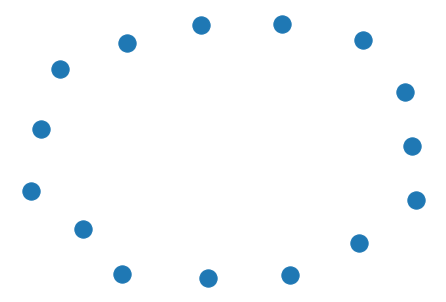

In [58]:
nx.draw(G)

So far, our graph is just a bunch of nodes without edges. Let's add some edges to that:

In [59]:
G.nodes[0]

{'topic1': 'compact_objects', 'topic2': 'agn'}

In [60]:
from astrochairs import add_edges

In [61]:
G = add_edges(G, labels=["topic1", "topic2"], hard_constraint=True)

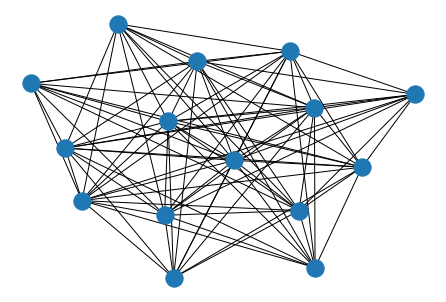

In [62]:
nx.draw(G)

There we go, the graph now has edges. Note that because we set a hard constraint, not all nodes are connected!

We can do the same with soft constraints, and the graph should be fully connected, though some connections might have a weight of zero:

In [63]:
G.remove_edges_from(G.edges())
G = add_edges(G, labels=["topic1", "topic2"], hard_constraint=False, weights=[1.0, 0.5])

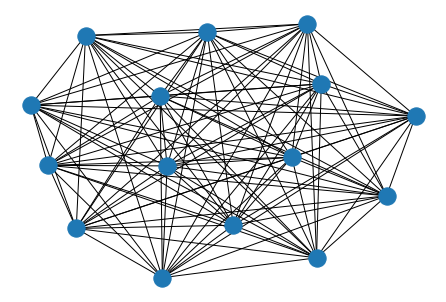

In [64]:
nx.draw(G)

In [65]:
G.edges()[0,1]

{'weight': 0.5}

But let's keep working with the constrained graph for now:

In [66]:
G.remove_edges_from(G.edges())
G = add_edges(G, labels=["topic1", "topic2"], hard_constraint=True, weights=[0.5])

Now that we've done that, all that's left to do is find a solution to our problem: find groups of size `n_elements` in the graph such that for the label `topic1` there are no clashes at all (two elements with the same value for `topic1` in the same group) and such that groups with doubles in `topic2` are less likely than those who don't have any clashes at all.

Note that `n_elements` must be chosen such that the number of nodes in the graph are an integer multiple of `n_elements`, that is, all nodes in principle separate cleanly into groups without any left over. 
Any choice for `n_elements` that does not satisfy this constraint currently throws an assertion error!

In [67]:
from astrochairs import find_solution

In [68]:
n_elements = 3
results = find_solution(G, n_elements)

Was the search a success?

In [69]:
results.success

True

Yes, it was. What's the solution?

In [70]:
results.groups

[[(2, {'topic1': 'agn', 'topic2': 'agn'}),
  (8, {'topic1': 'cosmology', 'topic2': 'cosmology'}),
  (14, {'topic1': 'exoplanets', 'topic2': 'compact_objects'})],
 [(1, {'topic1': 'compact_objects', 'topic2': 'agn'}),
  (4, {'topic1': 'stars', 'topic2': 'stars'}),
  (12, {'topic1': 'cosmology', 'topic2': 'cosmology'})],
 [(10, {'topic1': 'agn', 'topic2': 'stars'}),
  (11, {'topic1': 'cosmology', 'topic2': 'exoplanets'}),
  (13, {'topic1': 'galaxies', 'topic2': 'cosmology'})],
 [(6, {'topic1': 'exoplanets', 'topic2': 'agn'}),
  (7, {'topic1': 'cosmology', 'topic2': 'cosmology'}),
  (9, {'topic1': 'compact_objects', 'topic2': 'compact_objects'})],
 [(0, {'topic1': 'compact_objects', 'topic2': 'agn'}),
  (3, {'topic1': 'agn', 'topic2': 'exoplanets'}),
  (5, {'topic1': 'cosmology', 'topic2': 'stars'})]]

Looks about right. The third useful attribute is the sum of the combined weights of all groups:

In [71]:
results.weights_sum_total

15.0

## Using Numerical Similarity Instead of Topic

This problem should actually be much simpler: let's assume that "similarity" between two sessions can actually encoded in a numerical value between $0$ and $1$. 
This means we don't have to bother comparing strings, and we don't have to bother with multiple attributes to classes.

We can then write an interface that does two things: it either sets a hard constraint on whether sessions of a given similarity can be in the same time slot, or it uses a soft constraint maximizing the dis-similarity between sessions.

In [72]:
G = make_graph(node_ids=sessions, node_labels=labels)

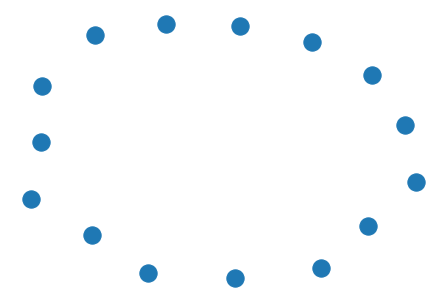

In [73]:
nx.draw(G)

We'll need to re-write `add_edges` such that it takes numerical values:

In [74]:
def add_edges(G, edges, hard_constraint=True, threshold=0.5):
    """
    Add edges to the graph, with weights. 
    Weights are determined by by the importance weights on 
    each label.

    If no order of labels is 
    specified, then the order of keys in the dictionary 
    for each node will be used.
    
    Parameters
    ----------
    G : networkx.Graph() instance
        The graph without edges
 
    hard_constraint : bool
        Boolean flag determining whether hard constraints should be used. 
        In this case, this means that for the first label specified in 
        `labels`, no edges will be drawn when this label is the same 
        for two nodes. 

    threshold: float out of [0,1]
        The threshold of the dissimilarity measure describing how dissimilar 
        two sessions are. If the threshold is small, the graph has a high tolerance 
        to similar sessions. That is, it is more likely to schedule similar sessions 
        at the same time. If it is small, then this tolerance is much smaller. There 
        will be much fewer edges between nodes. This means that there is a much 
        smaller chance that similar sessions will be scheduled at the same time. 
        However, fewer edges also means that there's a greater chance that no 
        solution will be found at all.
        
        
    Returns
    -------
    G : networkx.Graph() instance
        The same input graph, but with edges.
    """
    
    n_nodes = G.number_of_nodes()

    assert np.size(edges) == (n_nodes*(n_nodes - 1))/2.0, "Incorrect number of edges!"
    
    # counter for edges
    i = 0
    
    for k, n1 in enumerate(G.nodes()):
        for l, n2 in enumerate(G.nodes()):
            if k <= l:
                continue
            # if a hard constraint is set, make no edge 
            # if the edge weight is smaller than `threshold`,
            # otherwise set the weight edge to 1
            if hard_constraint:
                if edges[i] < threshold:
                    i += 1
                    continue
                else:
                    G.add_edge(n1, n2, weight=1.0)
            # otherwise just set all the weights the way they are
            else:
                G.add_edge(n1,n2,weight=edges[i])
            
            i += 1
            
    return G

Let's make some edges. We're going to randomly sample from a uniform distribution between zero and 1 for now. This will define the **dissimilarity** between two sessions. That is, the higher this value, the less likely two sessions are going to clash. This will probably be `1-d`, where `d` is the similarity measure some machine learning algorithm returns.

At the moment, edges are in a simple numpy-array that has the length of all possible edges. That will probably have to change if we get some kind of `Pandas DataFrame` or something similar.

In [75]:
# get the number of nodes
n_nodes = G.number_of_nodes()

n_edges = int(n_nodes*(n_nodes - 1)/2)

# define some edges
edges = np.random.uniform(0, 1, size=n_edges)

Now we can try the various versions. Let's try with a threshold of $0.5$. This should draw edges between about half of the nodes:

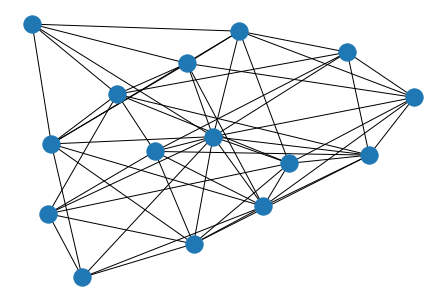

In [76]:
G.remove_edges_from(G.edges())
G = add_edges(G, edges, hard_constraint=True, threshold=0.5)
nx.draw(G)

In [77]:
print(G.number_of_edges())
print(len(edges[edges > 0.5]))

56
56


Let's try a smaller threshold:

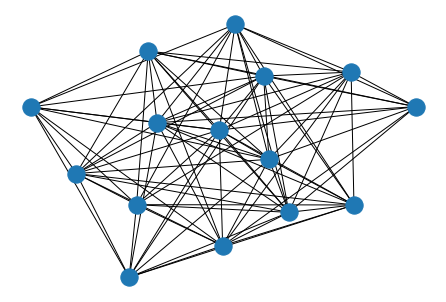

In [78]:
G.remove_edges_from(G.edges())
G = add_edges(G, edges, hard_constraint=True, threshold=0.2)
nx.draw(G)

In [79]:
print(G.number_of_edges())
print(len(edges[edges > 0.2]))

86
86


A smaller threshold means more edges, means a higher tolerance for sessions being at the same time! A higher threshold means that tolerance is smaller, but it also means that fewer edges are being drawn between nodes. Ultimately, this might mean that no solution will be found at all.

So if you're working with hard constraints, and you can't find a solution, try lowering the threshold, but check afterwards whether the solution is actually acceptable (if not, your problem might simple be fundamentally intractable). 

You can also simple assign all the weights to the edges and not have any hard constraints:

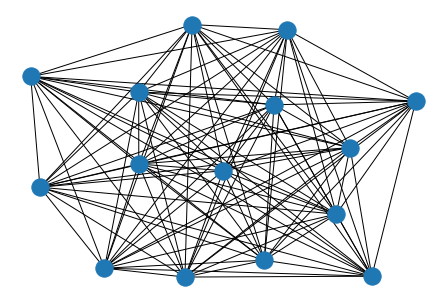

In [80]:
G.remove_edges_from(G.edges())
G = add_edges(G, edges, hard_constraint=False)
nx.draw(G)

Okay, cool. Next, we're going to have to find a solution!

In [81]:
def find_solution(G, n_elements, n_unused=None, results=None):
    """
    Sort nodes in G into groups of n_elements members such that 
    the total sum of weights is maximized. 
    If the graph includes hard constraints on the relationship between 
    nodes (i.e. missing edges), it is possible that no solution is found.
    
    In the case of a fully connected graph, the solution will be that 
    which maximizes the weights. The weights are inherent attributes of 
    the Graph and must be calculated beforehand (see `add_edges` for details).
    
    Parameters
    ----------
    G : networkx.Graph() instance
        Undirected graph with nodes and edges. The edges must have weights 
        between 0 and 1, but edges can be missing if no relationship exists 
        between nodes.
                
    n_elements : integer
        The number of elements per group. Must be an integer divisor of the 
        total number of nodes in the graph.
        
    n_unused : integer
        The number of unused nodes in the graph at every recursion step. 
        If None, then it will be initialized as the total number of nodes
        in the graph.
    
    weights_total_sum : list
        The total sum of weights of elements in `groups`. 
        If None, then it will be initialized as an empty list to count 
        the sum of weights for each individual group. Will be summed at 
        the end before output into a float value.
        Note: DO NOT SET THIS AT THE BEGINNING OF THE RUN!
        
    Returns
    -------
    success : bool
        Flag indicating success or failure of the algorithm
        
    groups: iterable
        A list of lists containing all groups of n_elements members fulfilling 
        the connectivity constraints that maximize the sum of weights of all 
        groups being used.        
        
    weights_total_sum : float
        The total sum of all weights of the output groups
    
    """

    assert G.number_of_nodes() % np.float(n_elements) == 0, "Number of sessions must be " + \
                                "an integer multiple of n_elements"


    ## initialize results object
    if results is None:
        results = Results(n_elements)

    if n_unused is None:
        n_unused = G.number_of_nodes()


    ## base case
    if n_unused == 0:
        results.success = True
        return results

    ## recursion
    else:
        ## find all cliques in the graph G
        cliques = list(nx.enumerate_all_cliques(G))

        ## find all cliques that have the required number of elements
        cliques = np.array([c for c in cliques if len(c)==n_elements])

        ## sort cliques by weights
        cliques, summed_weights = _sort_cliques_by_weights(G, cliques, n_elements)

        ## find the total number of cliques with n_elements members
        ncliques = len(cliques)

        ## loop over all cliques:
        for g,(cl,ww) in enumerate(zip(cliques, summed_weights)):
            cl_topics = [G.nodes()[c] for c in cl]

            ## add the new clique to the list of output groups
            results.update_groups(list(zip(cl, cl_topics)))

            ## add total weight of the clique:
            results.update_weights(ww)

            ## make a new deep copy for the next recursion step
            G_new = copy.deepcopy(G)

            ## remove clique from graph
            for n in cl:
                G_new.remove_node(n)

            ## compute new unused number of nodes
            n_unused = G_new.number_of_nodes()

            ## if no unused nodes are left, return the selected groups,
            ## otherwise recurse
            results = find_solution(G_new, n_elements, n_unused, results)
            if results is not None:
                if results.success:
                        return results

            ## backtrack
            else:
                results.success = False
                results.groups.pop(-1)
                results.all_weights.pop(-1)
                continue

    if len(results.groups) == 0:
        print("No solution found!")
        results.success = False
        return results

    else:
        results.groups.pop(-1)
        results.all_weights.pop(-1)

        results.success = False
        return results




Let's try with a graph that has a fairly high threshold:

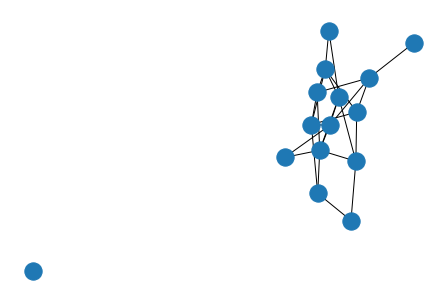

In [82]:
G.remove_edges_from(G.edges())
G = add_edges(G, edges, hard_constraint=True, threshold=0.8)
nx.draw(G)

In [83]:
n_elements = 3
results = find_solution(G, n_elements)

No solution found!


Predictably, there is no solution. Let's lower the threshold:

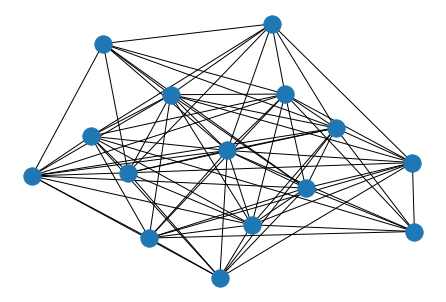

In [84]:
G.remove_edges_from(G.edges())
G = add_edges(G, edges, hard_constraint=True, threshold=0.3)
nx.draw(G)

In [85]:
n_elements = 3
results = find_solution(G, n_elements)

In [86]:
results.weights_sum_total

15.0

In [87]:
results.groups

[[(11, {'topic1': 'cosmology', 'topic2': 'exoplanets'}),
  (13, {'topic1': 'galaxies', 'topic2': 'cosmology'}),
  (14, {'topic1': 'exoplanets', 'topic2': 'compact_objects'})],
 [(9, {'topic1': 'compact_objects', 'topic2': 'compact_objects'}),
  (10, {'topic1': 'agn', 'topic2': 'stars'}),
  (12, {'topic1': 'cosmology', 'topic2': 'cosmology'})],
 [(0, {'topic1': 'compact_objects', 'topic2': 'agn'}),
  (2, {'topic1': 'agn', 'topic2': 'agn'}),
  (7, {'topic1': 'cosmology', 'topic2': 'cosmology'})],
 [(4, {'topic1': 'stars', 'topic2': 'stars'}),
  (5, {'topic1': 'cosmology', 'topic2': 'stars'}),
  (6, {'topic1': 'exoplanets', 'topic2': 'agn'})],
 [(1, {'topic1': 'compact_objects', 'topic2': 'agn'}),
  (3, {'topic1': 'agn', 'topic2': 'exoplanets'}),
  (8, {'topic1': 'cosmology', 'topic2': 'cosmology'})]]

Cool! There's a solution, so there seem to be sufficient triangles in the data to figure things out!

Let's also do the soft constraints, too:

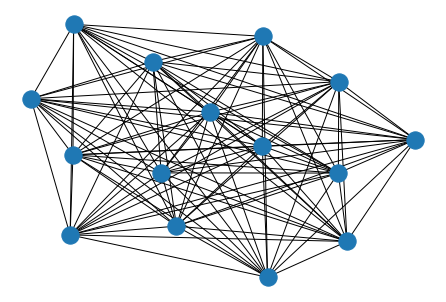

In [88]:
G.remove_edges_from(G.edges())
G = add_edges(G, edges, hard_constraint=False)
nx.draw(G)

In [89]:
n_elements = 3
results = find_solution(G, n_elements)

In [90]:
results.success

True

In [91]:
results.weights_sum_total

11.524697740972018

In [92]:
results.groups

[[(3, {'topic1': 'agn', 'topic2': 'exoplanets'}),
  (9, {'topic1': 'compact_objects', 'topic2': 'compact_objects'}),
  (12, {'topic1': 'cosmology', 'topic2': 'cosmology'})],
 [(5, {'topic1': 'cosmology', 'topic2': 'stars'}),
  (7, {'topic1': 'cosmology', 'topic2': 'cosmology'}),
  (13, {'topic1': 'galaxies', 'topic2': 'cosmology'})],
 [(0, {'topic1': 'compact_objects', 'topic2': 'agn'}),
  (8, {'topic1': 'cosmology', 'topic2': 'cosmology'}),
  (14, {'topic1': 'exoplanets', 'topic2': 'compact_objects'})],
 [(1, {'topic1': 'compact_objects', 'topic2': 'agn'}),
  (6, {'topic1': 'exoplanets', 'topic2': 'agn'}),
  (10, {'topic1': 'agn', 'topic2': 'stars'})],
 [(2, {'topic1': 'agn', 'topic2': 'agn'}),
  (4, {'topic1': 'stars', 'topic2': 'stars'}),
  (11, {'topic1': 'cosmology', 'topic2': 'exoplanets'})]]

And I think that's that part of the problem fixed!

In [93]:
G.number_of_nodes() % n_elements

0

### Let's look at the same problem using the module

The module has the same functions as above in `find_solution_numerical`:

In [94]:
from astrochairs import add_edges_numerical, find_solution_numerical

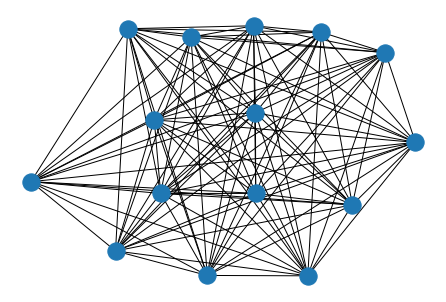

In [95]:
G.remove_edges_from(G.edges())
G = add_edges_numerical(G, edges, hard_constraint=False)
nx.draw(G)

In [96]:
n_elements = 3
results = find_solution_numerical(G, n_elements)

Caution! Number of sessions is not an integer multiple of the number of parallel slots!
Caution! Number of sessions is not an integer multiple of the number of parallel slots!
Caution! Number of sessions is not an integer multiple of the number of parallel slots!
Caution! Number of sessions is not an integer multiple of the number of parallel slots!
Caution! Number of sessions is not an integer multiple of the number of parallel slots!
Caution! Number of sessions is not an integer multiple of the number of parallel slots!


In [97]:
results.success

True

In [98]:
results.groups

[[(3, {'topic1': 'agn', 'topic2': 'exoplanets'}),
  (4, {'topic1': 'stars', 'topic2': 'stars'}),
  (5, {'topic1': 'cosmology', 'topic2': 'stars'})],
 [(7, {'topic1': 'cosmology', 'topic2': 'cosmology'}),
  (9, {'topic1': 'compact_objects', 'topic2': 'compact_objects'}),
  (14, {'topic1': 'exoplanets', 'topic2': 'compact_objects'})],
 [(8, {'topic1': 'cosmology', 'topic2': 'cosmology'}),
  (12, {'topic1': 'cosmology', 'topic2': 'cosmology'}),
  (13, {'topic1': 'galaxies', 'topic2': 'cosmology'})],
 [(0, {'topic1': 'compact_objects', 'topic2': 'agn'}),
  (6, {'topic1': 'exoplanets', 'topic2': 'agn'}),
  (10, {'topic1': 'agn', 'topic2': 'stars'})],
 [(1, {'topic1': 'compact_objects', 'topic2': 'agn'}),
  (2, {'topic1': 'agn', 'topic2': 'agn'}),
  (11, {'topic1': 'cosmology', 'topic2': 'exoplanets'})]]

Hooray, that's working, too!